# K-Nearest neighbors

We consider a simple supervised classification method based on similarity between inputs, in order to highlight issues related to model validation (choice of hyperparameters). Essentially, it consists in finding the $K$ nearest neighboring point of a new data point, and predict the label of the new data point based on the empirical frequencies within the $K$ neighbors which were found. When $K=1$, the training error is 0, but the test error may be large as overfitting is observed. When $K$ is large, the decision boundaries are much smoother, but the large number of neighbors considered leads to underfitting and large training errors (hence also large test errors).

**There are 8 questions to answer.**

## Simple example with decision boundaries

We first visualize the behavior of kNN with decision boundaries. The code below is based on 
https://colab.research.google.com/github/tvhahn/Beautiful-Plots/blob/master/Decision%20Boundary/decision-boundary.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import neighbors
import seaborn as sns;
import pandas as pd

We consider the iris dataset https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html There are three possible labels: 0,1,2.

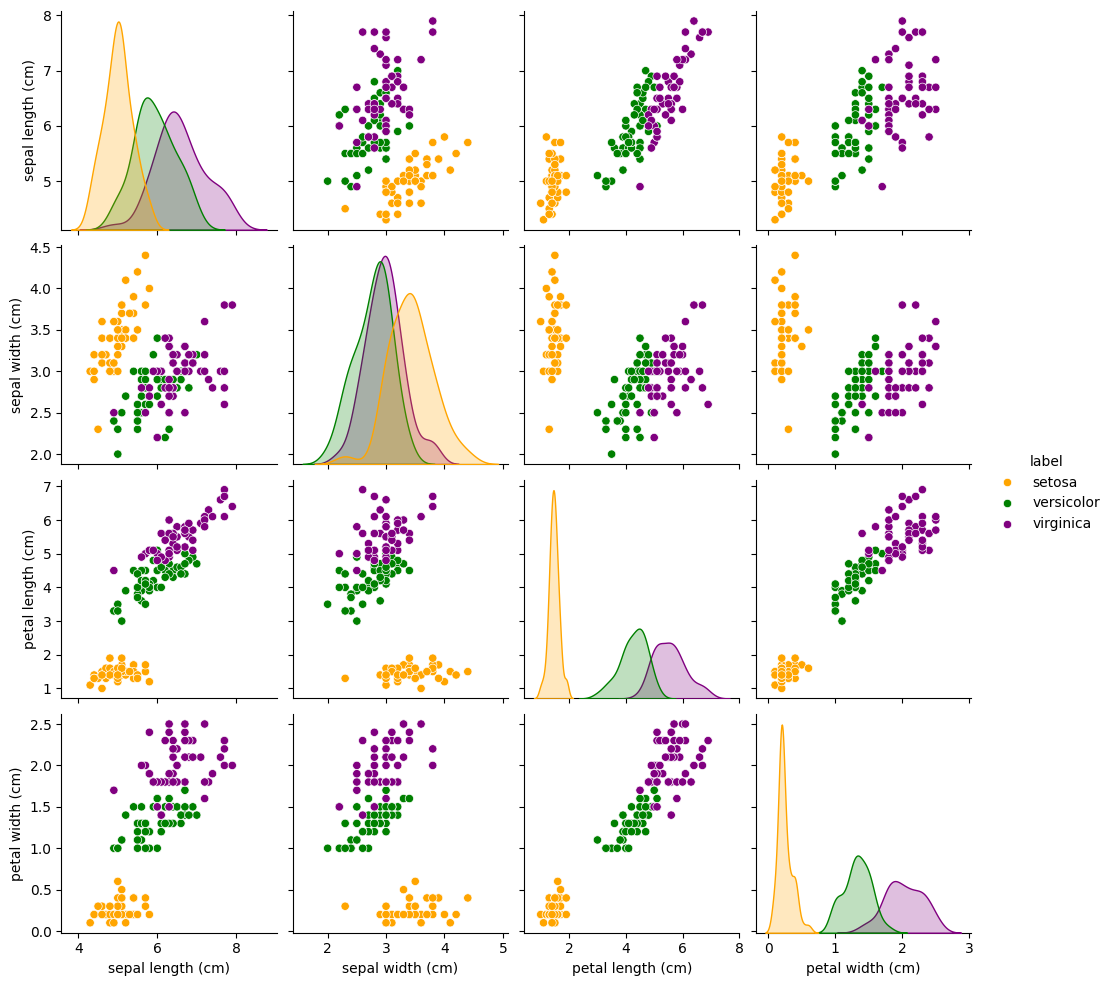

In [2]:
iris = datasets.load_iris()
x = iris.data
y = iris.target

# Convert to pandas dataframe 
df = pd.DataFrame(data=x, columns=iris.feature_names)
df['label'] = pd.Series(iris.target_names[y], dtype='category')

# plot the results
palette = {'setosa': 'orange', 'versicolor': 'green', 'virginica': 'purple'}
sns.pairplot(df, vars = df.columns[0:4], hue="label", palette=palette)
plt.show()

We retain only the first two columns of the $x$ points.

In [3]:
# Sepal length and width
x = iris.data[:,0:2]
# Petal length and width
# x = iris.data[:,2:4]
y = iris.target

# print the shape of the data to
# better understand it
print('data shape:', x.shape)
print('label shape:', y.shape)

data shape: (150, 2)
label shape: (150,)


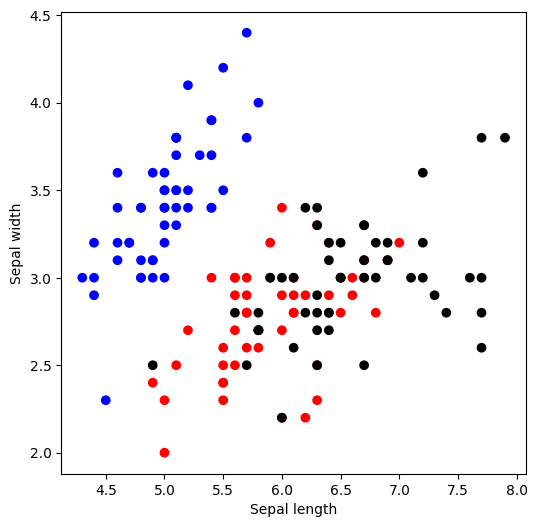

In [4]:
# create the x0, x1 feature
x0 = x[:,0]
x1 = x[:,1]

chosen_colors = np.array(['blue', 'red', 'black'])
plt.figure(figsize=(6,6))
plt.scatter(x0, x1, c=chosen_colors[y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

We use the K-nearest neighbor method implemented in Scikit learn.

In [5]:
N_NEIGHBORS = 3 # KNN number of neighbors
clf = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
clf.fit(x, y)

KNeighborsClassifier(n_neighbors=3)

We create a grid to evaluate the classifier.

In [6]:
PAD = 1.0 # how much to "pad" around the min/max values of the data, to set the bounds of the plots
H = 0.1 # mesh stepsize

# creating the mesh
x0_min, x0_max = np.round(x0.min())-PAD, np.round(x0.max()+PAD)
x1_min, x1_max = np.round(x1.min())-PAD, np.round(x1.max()+PAD)
x0_axis_range = np.arange(x0_min,x0_max,H)
x1_axis_range = np.arange(x1_min,x1_max,H)
xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)

# checking the shape of the mesh
print('Mesh size')
print('xx0.shape:', xx0.shape)
print('xx1.shape:', xx1.shape,'\n')

# reshaping all grid points as lines, using ravel() to flatten
# see https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
xx = np.stack((xx0.ravel(),xx1.ravel()),axis=1)
print('After reshaping')
print('xx.shape:', xx.shape)

Mesh size
xx0.shape: (40, 60)
xx1.shape: (40, 60) 

After reshaping
xx.shape: (2400, 2)


We next compute predictions on the grid.

In [7]:
# prediction at all grid points: 
# - probability vector (3 dimensional vector with entries summing to 1)
yy_prob = clf.predict_proba(xx) 
# - class of maximal probability
yy_hat = clf.predict(xx) 
                               
# for display: size of each probability dot
yy_size = np.max(yy_prob, axis=1) 

We can then plot the decision boundaries and various other useful information.

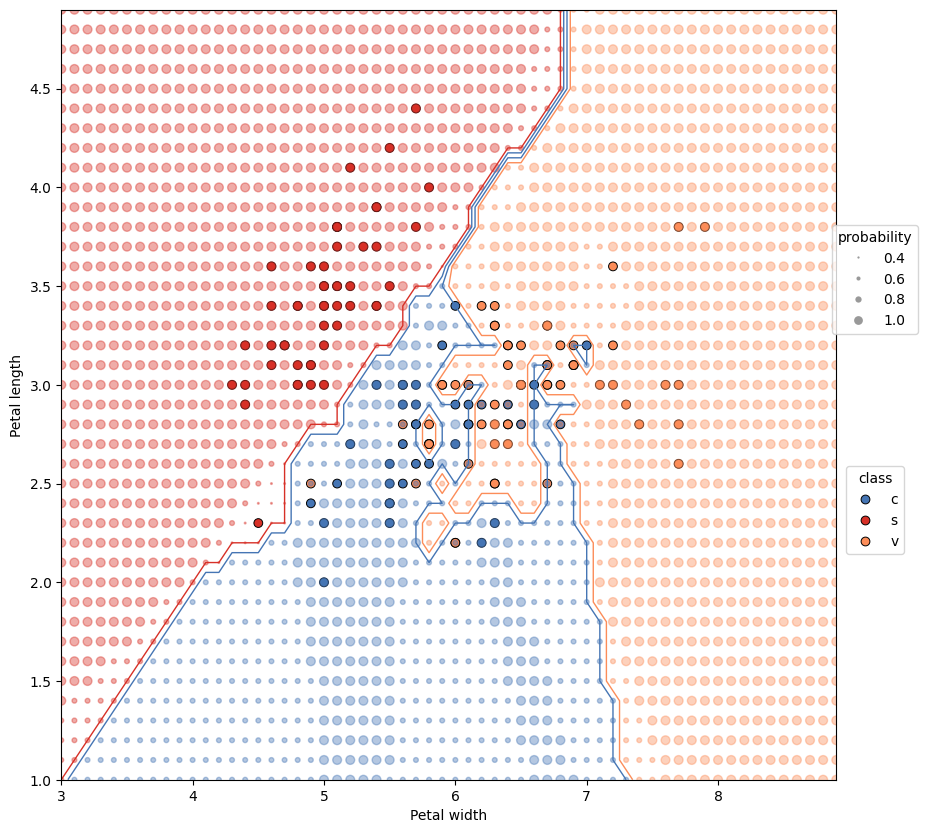

In [8]:
# Parameters for dots in scatter plots
PROB_DOT_SCALE = 40       # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3  # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 40        # size of the true labels

# Choice of colors and colormap (using colors adequate for color blind people, see https://bit.ly/3qJ6LYL)
redish = '#d73027'
orangeish = '#fc8d59'
yellowish = '#fee090'
blueish = '#4575b4'
colormap = np.array([redish,blueish,orangeish])

from matplotlib.lines import Line2D       # for creating the custom legend
from matplotlib import pyplot             # to re-add a legend later on
plt.figure(figsize=(10,10))
plt.grid(False) # remove gridlines 

# We start by plotting the training data 
# The parameter zorder is set to a positive value so that the dots appear above all other elements 
plt.scatter(x[:,0], x[:,1], c=colormap[y], s=TRUE_DOT_SIZE, zorder=1, linewidths=0.7, edgecolor='k')

# We first plot the dots corresponding to the estimation at the grid points 
# The positions are defined by the xx values, and the color by the KNN predictions yy_hat
# The size of the dots is proportional to yy_size^3 
plt.scatter(xx[:,0],xx[:,1],c=colormap[yy_hat],alpha=0.4,s=PROB_DOT_SCALE*yy_size**PROB_DOT_SCALE_POWER)

# We next represent contours plot
# The yy_hat has to be reshaped as a matrix corresponding to the x0 and x1 axes
# The number of levels was manually tuned for this data, and would need to be changed for more classes
plt.contour(x0_axis_range, x1_axis_range,np.reshape(yy_hat,(xx0.shape[0],-1)),
            levels=3,linewidths=1,colors=[redish,blueish, blueish,orangeish,])

# axes names for Sepal length and width
# plt.ylabel('Sepal length')
# plt.xlabel('Sepal width')

# axes names for Petal length and width
plt.ylabel('Petal length')
plt.xlabel('Petal width')

# first legend: classes
legend_class = []
for flower_class, color in zip(['c', 's', 'v'], [blueish, redish, orangeish]):
    legend_class.append(Line2D([0], [0], marker='o', label=flower_class,ls='None',markerfacecolor=color, 
        markersize=np.sqrt(TRUE_DOT_SIZE),markeredgecolor='k', markeredgewidth=0.7))
legend1 = plt.legend(handles=legend_class, loc='center',bbox_to_anchor=(1.05, 0.35),frameon=True,title='class')
# second legend: probabilities
prob_values = [0.4, 0.6, 0.8, 1.0]
legend_prob = []
for prob in prob_values:
    legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,markerfacecolor='grey', 
        markersize=np.sqrt(PROB_DOT_SCALE*prob**PROB_DOT_SCALE_POWER),markeredgecolor='k', markeredgewidth=0))
legend2 = plt.legend(handles=legend_prob, loc='center',bbox_to_anchor=(1.05, 0.65),frameon=True,title='probability')
# to re-add the first legend, erased after the second one is plotted
pyplot.gca().add_artist(legend1)
plt.show()

**Question 1.** Change the values of $K$ and discuss how the decision boundaries change. Consider also using the petal width and length instead of the sepal width and length. Describe in the cell below your observations, and say also which lines of code need to be changed to use the petal data instead of the sepal one.


Concerning sepal width and length, when we take a small value of $K$ (eg $K=3$), the decision boudaries are more destructed. We can find small "clusters" in the different zones. The boudaries includes every extreme points and that's what creates this destructured aspect. The blue zone is larger.

When we take a large value of $K$ (eg $K=30$), the decision boudaries are much more smooth. There is no little bubble (compared to what we had before). Globally, for a large $K$, the classifier is less accurate.

The lines of code that need to be changed to use the petal data instead of the sepal one are: 
`x = iris.data[:,2:4]` instead of `x = iris.data[:,0:2]`

We can notice that we would have better results if we have had used the petal data instead of the sepal one because the bouderies are clearer, more visible and smoother than what we have. The different classes are well separated. The classifier would classify better.

## Finding the number of neighbors by cross-validation

Since data is scarce and cannot be generated, we consider cross-validation to estimate the optimal number of neighbords $K$ to consider. We first use the built-in scikit-learn function.

In [9]:
from sklearn.model_selection import cross_val_score

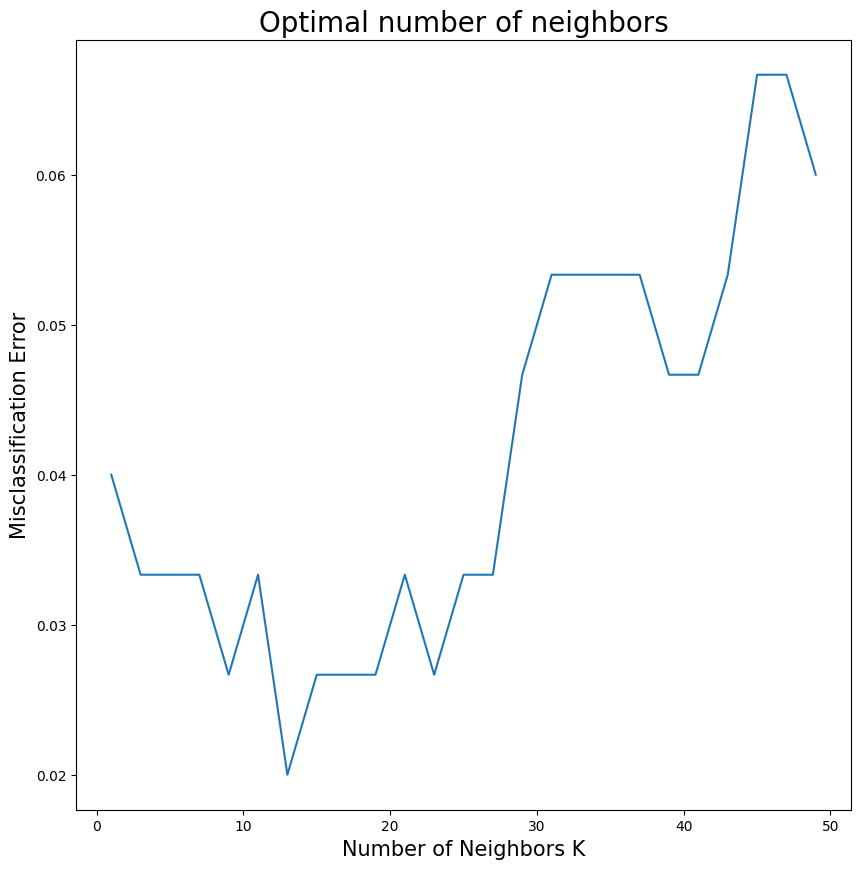

In [10]:
n_fold = 10

iris = datasets.load_iris()
x = iris.data
y = iris.target

# creating list of K for KNN
k_list = list(range(1,50,2))
# creating list of cv scores
cv_scores = []

# perform n-fold cross validation
for k in k_list:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=n_fold, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - t for t in cv_scores]

plt.figure(figsize=(10,10))
plt.title('Optimal number of neighbors', fontsize=20)
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
plt.plot(k_list, MSE)
plt.show()

**Question 2.** Write a short code giving the optimal number of neighbors found by cross validation. How does this number change when the number of folds is varied?

When the number of folds is small (eg $n\_fold = 3$), the optimal number of neighbors is smaller ($5$) whereas for a large number of folds (eg $n\_fold = 30$), the optimal number of neighbors is larger ($19$).

In [11]:
# Optimal number of neighbors found by cross validation
best_k = k_list[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d." % best_k)

The optimal number of neighbors is 13.


## Implementing KNN from scratch

We now implement KNN from scratch -- first the method itself, and then cross-validation.

**Question 3.** Complete, in the code below, the function *_predict*, which predicts the label for a given input.

In [12]:
from collections import Counter

class KNN:

    # initialization
    def __init__(self, K=3):
        self.k = K

    # memorizing the training set in order to make predictions
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # calling the function _predict on each input point in order to perform prediction for a vector of inputs
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    # actual prediction function ---------> TO COMPLETE 
    def _predict(self, x):
        label = 0
        # Compute distances between x and all examples in the training set
        distances = np.linalg.norm(self.X_train - x, axis=1)
        
        # Sort by distance and return indices of the first k neighbors
        # see for instance https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
        k_neighbors_indices = np.argsort(distances)[:self.k]
        
        # Extract the labels of the k nearest neighbor training samples
        k_neighbor_labels = self.y_train[k_neighbors_indices]
        
        # return the most common class label
        # use for instance https://docs.python.org/3/library/collections.html#collections.Counter.most_common
        label = Counter(k_neighbor_labels).most_common(1)[0][0]
        
        return label

We first do a validation based on splitting the data intro a training and a validation set.

In [13]:
split_ratio = 0.8

# we first shuffle the data
Ndata = x.shape[0]
indices = np.random.permutation(Ndata) 
x = x[indices]
y = y[indices]

# we then separate it into a train and validation set
N_train = round(split_ratio*Ndata)
x_train = x[0:N_train]
y_train = y[0:N_train]
x_validation = x[N_train:Ndata]
y_validation = y[N_train:Ndata]

print(x_validation.shape)

(30, 4)


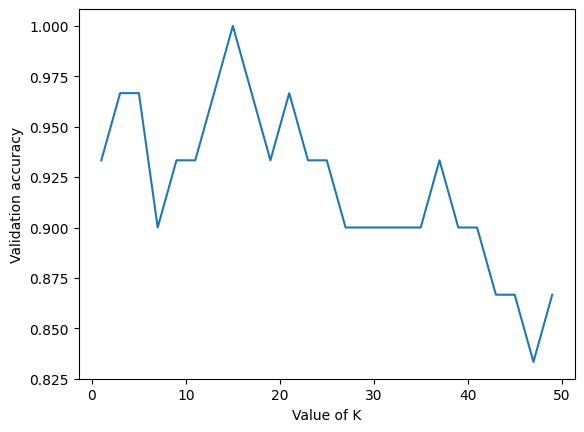

In [14]:
from sklearn.metrics import accuracy_score

# creating list of K for KNN
k_list = list(range(1,50,2))

accuracies = []

for k in k_list:
  model = KNN(K = k)
  model.fit(x_train, y_train)
  pred = model.predict(x_validation)
  # compute the fraction of correctly predicted labels using built-in functions
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  acc = accuracy_score(y_validation, pred)
  accuracies.append(acc)
    
plt.figure()
plt.plot(k_list,accuracies)
plt.xlabel('Value of K')
plt.ylabel('Validation accuracy')
plt.show()

Since the data set is small, it is in fact better to code cross-validation.

**Question 4.** Complete the code below to implement cross-validation:
- The function *kfold_split* splits the training inputs into the desired number of folds, by returning a list of indices, the i-th element of the list being of the set of indices of input points in the i-th fold.
- The function *custom_cross_val_score* returns the mean prediction score based on an average over the results obtained by taking one fold as the validation set, and the remaining folds as the training set.

In [15]:
np.random.seed(42) # for reproducibility

# creates the list of indices to consider for each fold
def kfold_split(Ndata, n_folds):
    indices_list = []
    n_elements = int(Ndata/n_folds) # number of elements to consider in each fold
    indices = list(range(Ndata))  
    np.random.shuffle(indices)      # shuffle the set of integers 1, 2, ..., Ndata

    for i in range(n_folds):
        # append to indices_list the array of indices corresponding to the i-th fold
        indices_list.append(indices[i*n_elements:(i+1)*n_elements])
    return indices_list

In [16]:
# arguments of the function = full data set (x,y), value of k for KNN, and number of folds to consider
def custom_cross_val_score(x, y, k, n_fold):
    model = KNN(K = k)
    score = np.zeros(n_fold)
    # indices for each fold
    ind = kfold_split(x.shape[0],n_fold)
    # loop over the folds
    for i in range(n_fold):
        # creation of the train set = full dataset without i-th fold
        # using the function https://numpy.org/doc/stable/reference/generated/numpy.delete.html
        # could alternatively consider concatenating with np.concatenate, but longer to code...
        xtrain = np.delete(x, ind[i], axis=0)
        ytrain = np.delete(y, ind[i], axis=0)
        # creation of the validation set = i-th fold
        xval = x[ind[i]]
        yval = y[ind[i]]
        # we can now compute the predictions for these datasets
        model.fit(xtrain, ytrain)
        pred = model.predict(xval)
        # add the score to the vector of scores
        score[i] = accuracy_score(yval,pred)
    return np.mean(score)

**Question 5.** Run the cross-validation procedure with the custom function, and compare the results with the ones obtained by the built-in scikit-learn function (see above).

We can notice that the optimal number of neighbours found by our custom function is equal to $7$ which is the same as the one found by the built-in scikit-learn function.

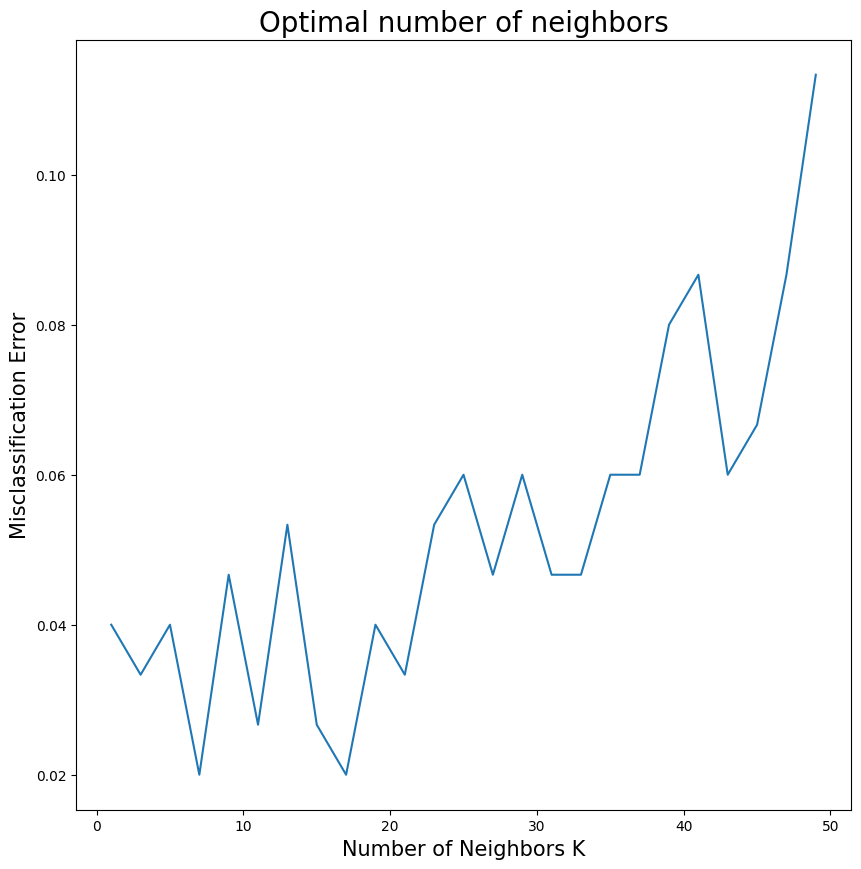

In [17]:
n_fold = 5

# reload the dataset
iris = datasets.load_iris()
x = iris.data
y = iris.target

# creating list of K for KNN
k_list = list(range(1,50,2))

# creating list of cv scores
cv_scores = []

# perform n-fold cross validation
for k in k_list:
    mean_score = custom_cross_val_score(x, y, k, n_fold)
    cv_scores.append(mean_score)
    
# changing to misclassification error
MSE = [1 - t for t in cv_scores]

plt.figure(figsize=(10,10))
plt.title('Optimal number of neighbors', fontsize=20)
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
plt.plot(k_list, MSE)
plt.show()

In [18]:
# Optimal number of neighbors found by cross validation
best_k = k_list[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d." % best_k)

The optimal number of neighbors is 7.


## MNIST data set

In order to more quantitatively study KNN, and in particular have more inputs, we use the MNIST dataset. 

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# set up the random number generator: given seed for reproducibility, None otherwise
# (see https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng)
my_seed = 1
rng = np.random.default_rng(seed=my_seed) 

In [20]:
# load data from Keras, values between 0 and 255 initially
(x_train_full, y_train_full), (x_test_full, y_test_full) = tf.keras.datasets.mnist.load_data()
print('initial data type for images = ',x_train_full.dtype,', initial data shape = ',x_train_full.shape)
print('initial data type for labels = ',y_train_full.dtype,', initial label shape = ',y_train_full.shape,'\n')
    
# renormalize to have data between 0 and 1; could alternatively use built-in rescaling function
# such as https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
x_train_full = x_train_full/255. 
x_test_full = x_test_full/255.
print('Train set: data set size =',x_train_full.shape[0])
print('Test set:  data set size =',x_test_full.shape[0])

# reshape the data points, which are 28x28 tensors, into a single vector of size 28x28=784
x_train_full = x_train_full.reshape((x_train_full.shape[0], 784))
x_test_full = x_test_full.reshape((x_test_full.shape[0], 784))

# shuffle data
indices = np.random.permutation(x_train_full.shape[0])
x_train_full = x_train_full[indices]
y_train_full = y_train_full[indices]
indices = np.random.permutation(x_test_full.shape[0])
x_test_full = x_test_full[indices]
y_test_full = y_test_full[indices]

initial data type for images =  uint8 , initial data shape =  (60000, 28, 28)
initial data type for labels =  uint8 , initial label shape =  (60000,) 

Train set: data set size = 60000
Test set:  data set size = 10000


We can plot the first elements of the resulting data set in order to see what they looks like.

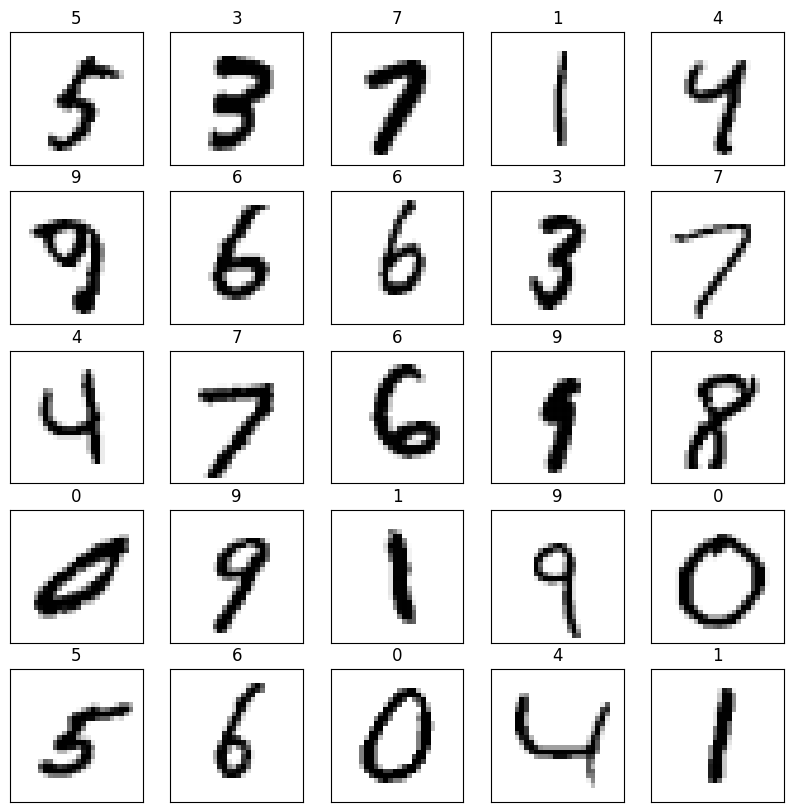

In [21]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # color map = binary, other choices here https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.imshow(x_train_full[i].reshape(28,28), cmap=plt.cm.binary)     
    plt.title(y_train_full[i])
plt.show()

We extract a smaller data set for training since the method does not scale well with the number of data points (the data has already been shuffled).

Initial dimension of the training data: (60000, 784)
After subsampling at rate 25 : (2400, 784)
Initial dimension of the test data: (10000, 784)
After subsampling at rate 10 : (1000, 784)


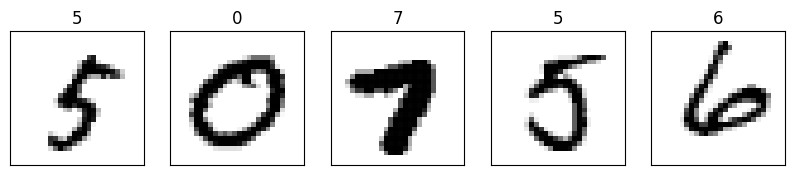

In [22]:
# train subsampling rate: the final number of training images is 60000 divided by this number
train_subsampling_rate = 25
# test subsampling rate: the final number of training images is 10000 divided by this number
test_subsampling_rate = 10

# syntax for subsampling: start:sto:step 
x_train = x_train_full[0::train_subsampling_rate]
y_train = y_train_full[0::train_subsampling_rate]
print('Initial dimension of the training data:',x_train_full.shape)
print('After subsampling at rate',train_subsampling_rate,':',x_train.shape)
x_test = x_test_full[0::test_subsampling_rate]
y_test = y_test_full[0::test_subsampling_rate]
print('Initial dimension of the test data:',x_test_full.shape)
print('After subsampling at rate',test_subsampling_rate,':',x_test.shape)

# we replot some data to make sure that the data reduction was done correctly
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # color map = binary, other choices here https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.imshow(x_train[i].reshape(28,28), cmap=plt.cm.binary)     
    plt.title(y_train[i])
plt.show()

**Question 6.** Run the KNN method to identify the best value of $K$ by cross-validation (see code to complete below). Start by a rather broad range of values, and then refine by increasing the sizes of the datasets (both test and train).

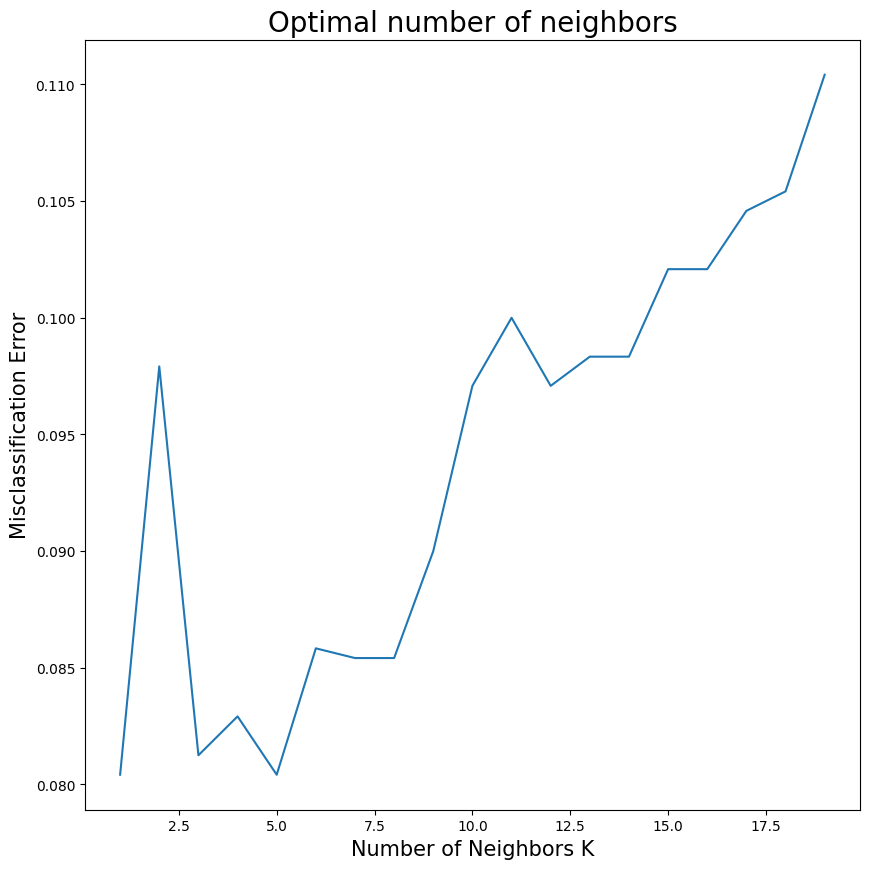

In [23]:
n_fold = 50

# creating list of K for KNN
k_list = list(range(1,20,1))
# creating list of cv scores
cv_scores = []

# perform n-fold cross validation
for k in k_list:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=n_fold, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - t for t in cv_scores]

plt.figure(figsize=(10,10))
plt.title('Optimal number of neighbors', fontsize=20)
plt.xlabel('Number of Neighbors K', fontsize=15)
plt.ylabel('Misclassification Error', fontsize=15)
plt.plot(k_list, MSE)
plt.show()

Write below the code to find the best value of $K$.

In [24]:
# Optimal number of neighbors found by cross validation
best_k = k_list[1:][MSE[1:].index(min(MSE[1:]))]
print("The optimal number of neighbors is %d." % best_k)

The optimal number of neighbors is 5.


We can in fact make use of the test set, used as a validation set.

**Question 7.** Re-run the model validation procedure to identify the optimal value of $K$ by training the model on the training data, and computing the validation loss with the test data.

In [25]:
from sklearn.metrics import accuracy_score

kVals = np.arange(1,10,2)
accuracies = []

for k in kVals:
  model = KNN(K = k)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  # compute the fraction of correctly predicted labels using built-in functions
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  acc = accuracy_score(y_test, pred)
  accuracies.append(acc)
  print("K = "+str(k)+": accuracy: "+str(acc))
    
plt.figure()
plt.plot(kVals,accuracies)
plt.xlabel('Value of K')
plt.ylabel('Validation accuracy')
plt.show()

KeyboardInterrupt: 

In [ ]:
# FINDING THE BEST VALUE OF K
best_k = kVals[accuracies.index(max(accuracies))]
print("The optimal number of neighbors is %d." % best_k)

The optimal number of neighbors is 5.


**Question 8.** Classification errors can also be quantified by looking at the confusion matrix. Compute this matrix for the optimal value of $K$ found in the previous question. 

In [ ]:
# from sklearn.model_selection import train_test_split

# # Assuming you have x_data and y_data as your complete dataset
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [26]:
model = KNN(K = 5) # TO COMPLETE
model.fit(x_train, y_train)
pred = model.predict(x_test)
acc = accuracy_score(y_test, pred)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred) # could be normalized by the extra argument normalize='true' for instance

array([[ 97,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 120,   0,   1,   0,   0,   0,   0,   0,   0],
       [  4,   4,  76,   2,   3,   1,   3,   6,   1,   0],
       [  0,   0,   1,  85,   0,   3,   0,   2,   1,   2],
       [  0,   3,   0,   0,  92,   0,   3,   0,   0,   8],
       [  0,   1,   0,   6,   0,  71,   3,   0,   1,   2],
       [  1,   1,   0,   0,   0,   1,  94,   0,   0,   0],
       [  0,   3,   0,   0,   0,   0,   0,  86,   0,   2],
       [  2,   0,   1,   3,   1,   5,   0,   1,  76,   4],
       [  1,   1,   0,   1,   6,   0,   0,   3,   0, 105]], dtype=int64)